In [ ]:
"""Original: momemntum = 0.5 to 0.8, learning rate=500, max_iter_thresh=20
Exp01: momemntum = 0.1 to 0.8, learning rate=500, max_iter_thresh=20, max_iter = 1000
Exp02: momemntum = 0.1 to 0.5, learning rate=500, max_iter_thresh=20, max_iter = 1000
Exp03: momemntum = 0.1 to 1, learning rate=500, max_iter_thresh=20, max_iter = 1000
Exp04: momemntum = 1 to 2, learning rate=500, max_iter_thresh=20, max_iter = 1000 --> Runs into warning (divide by zero encountered in true_divide)
Exp05: momemntum = 0.1 to 2, learning rate=500, max_iter_thresh=20, max_iter = 1000 --> Runs into warning (divide by zero encountered in true_divide)
Exp06: momemntum = 0.5 to 0.8, learning rate=500, max_iter_thresh=250, max_iter = 1000
Exp07: momemntum = 0.5 to 0.8, learning rate=500, max_iter_thresh=250, max_iter = 500
Exp08: momemntum = 0.5 to 0.8, learning rate=500, max_iter_thresh=20, max_iter = 500
Exp09: momemntum = 0.5 to 0.8, learning rate=500, max_iter_thresh=20, max_iter = 1500
Exp10: momemntum = 0.5 to 0.8, learning rate=500, max_iter_thresh=20, max_iter = 2000
Exp11: momemntum = 0.5 to 0.8, learning rate=100, max_iter_thresh=20, max_iter = 1000
Exp12: momemntum = 0.5 to 0.8, learning rate=50, max_iter_thresh=20, max_iter = 1000
Exp13: momemntum = 0.5 to 0.8, learning rate=250, max_iter_thresh=20, max_iter = 1000"""

In [1]:
import keras
import numpy as np
from sklearn import datasets
%matplotlib inline                                 
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace  
import pandas as pd
import seaborn as sns
import os
import pylab

np.random.seed(1234)

In [2]:
faces = datasets.fetch_olivetti_faces()

X = faces.data
labels = faces.target

In [3]:
print(X.shape, labels.shape)
print(np.amin(X), np.amax(X))
print(labels)

(400, 4096) (400,)
0.0 1.0
[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9
  9  9  9  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 14 14 14 14
 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16
 16 16 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21
 21 21 21 21 22 22 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23
 24 24 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 26 26 26 26
 26 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28
 28 28 29 29 29 29 29 29 29 29 29 29 30 30 30 30 30 30 30 30 30 30 31 31
 31 31 31 31 31 31 31 31

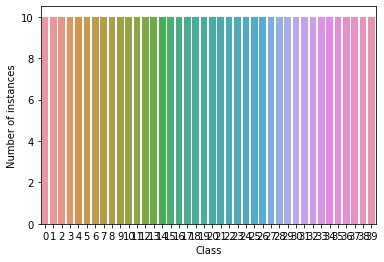

In [4]:
df = pd.DataFrame(data=labels, columns=['class'])
ax = sns.countplot(x='class', data=df)
ax.set(xlabel='Class', ylabel='Number of instances')
plt.show()

In [5]:
def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000 #The number of gradient descent iterations T
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 400...
Mean value of sigma: 3.791231
Iteration 10: error is 14.747793
Iteration 20: error is 13.763548
Iteration 30: error is 13.514959
Iteration 40: error is 13.642861
Iteration 50: error is 13.624439
Iteration 60: error is 13.585740
Iteration 70: error is 13.628607
Iteration 80: error is 13.694078
Iteration 90: error is 13.580275
Iteration 100: error is 13.573085
Iteration 110: error is 1.109292
Iteration 120: error is 0.667192
Iteration 130: error is 0.543866
Iteration 140: error is 0.495181
Iteration 150: error is 0.469032
Iteration 160: error is 0.454182
Iteration 170: error is 0.444891
Iteration 180: error is 0.438927
Iteration 190: error is 0.434815
Iteration 200: error is 0.431043
Iteration 210: error is 0.429016
Iteration 220: error is 0.426342
Iteration 230: er

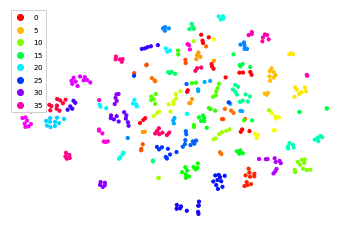

In [8]:
#Run original script parameters
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne(X, 2, 50, perplexity=30.0)
    fig, ax = plt.subplots()
    scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
    plt.axis('off')
    legend = ax.legend(*scatter.legend_elements(), fontsize=7)
    ax.add_artist(legend)
    plt.show()

In [7]:
#initial and final parameter changed
def tsne_exp1(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000 #The number of gradient descent iterations T
    initial_momentum = 0.1
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 400...
Mean value of sigma: 3.791231
Iteration 10: error is 14.808779
Iteration 20: error is 13.990689
Iteration 30: error is 13.428400
Iteration 40: error is 13.568250
Iteration 50: error is 13.548586
Iteration 60: error is 13.516027
Iteration 70: error is 13.540524
Iteration 80: error is 13.550082
Iteration 90: error is 13.535516
Iteration 100: error is 13.534730
Iteration 110: error is 1.021142
Iteration 120: error is 0.599211
Iteration 130: error is 0.495494
Iteration 140: error is 0.455521
Iteration 150: error is 0.435223
Iteration 160: error is 0.423423
Iteration 170: error is 0.416421
Iteration 180: error is 0.412371
Iteration 190: error is 0.409744
Iteration 200: error is 0.407948
Iteration 210: error is 0.406662
Iteration 220: error is 0.405690
Iteration 230: er

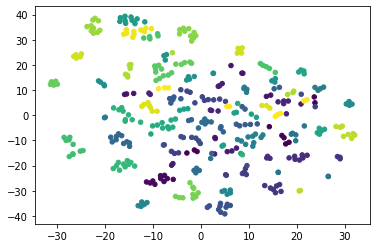

Wall time: 2min 14s


In [8]:
%%time
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne_exp1(X, 2, 50, perplexity=30.0)
    pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
    pylab.show()

In [24]:
#initial and final parameter changed
def tsne_exp2(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000 #The number of gradient descent iterations T
    initial_momentum = 0.1
    final_momentum = 0.5
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 400...
Mean value of sigma: 3.791231
Iteration 10: error is 15.143742
Iteration 20: error is 14.396933
Iteration 30: error is 13.589573
Iteration 40: error is 13.543088
Iteration 50: error is 13.543698
Iteration 60: error is 13.543814
Iteration 70: error is 13.543995
Iteration 80: error is 13.544083
Iteration 90: error is 13.544083
Iteration 100: error is 13.544128
Iteration 110: error is 1.184256
Iteration 120: error is 0.774468
Iteration 130: error is 0.622443
Iteration 140: error is 0.551269
Iteration 150: error is 0.509241
Iteration 160: error is 0.482011
Iteration 170: error is 0.463416
Iteration 180: error is 0.450206
Iteration 190: error is 0.440457
Iteration 200: error is 0.433159
Iteration 210: error is 0.427539
Iteration 220: error is 0.423306
Iteration 230: er

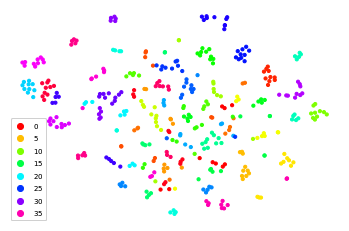

Wall time: 1min 3s


In [26]:
%%time
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne_exp2(X, 2, 50, perplexity=30.0)
    fig, ax = plt.subplots()
    scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
    plt.axis('off')
    legend = ax.legend(*scatter.legend_elements(), fontsize=7)
    ax.add_artist(legend)
    plt.show()

In [27]:
#initial and final parameter changed
def tsne_exp3(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000 #The number of gradient descent iterations T
    initial_momentum = 0.1
    final_momentum = 1
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 400...
Mean value of sigma: 3.791231
Iteration 10: error is 14.711025
Iteration 20: error is 13.979929
Iteration 30: error is 13.176439
Iteration 40: error is 14.172411
Iteration 50: error is 14.061835
Iteration 60: error is 13.353493
Iteration 70: error is 13.491731
Iteration 80: error is 13.703627
Iteration 90: error is 13.487271
Iteration 100: error is 13.113226
Iteration 110: error is 2.239097
Iteration 120: error is 2.300037
Iteration 130: error is 2.236488
Iteration 140: error is 2.209762
Iteration 150: error is 2.147833
Iteration 160: error is 2.084318
Iteration 170: error is 2.062495
Iteration 180: error is 2.025917
Iteration 190: error is 2.010053
Iteration 200: error is 1.987427
Iteration 210: error is 1.974564
Iteration 220: error is 1.973195
Iteration 230: er

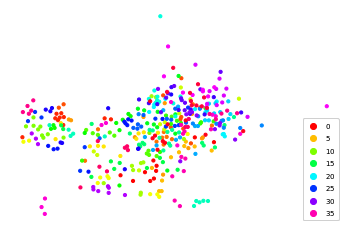

Wall time: 1min 7s


In [28]:
%%time
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne_exp3(X, 2, 50, perplexity=30.0)
    fig, ax = plt.subplots()
    scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
    plt.axis('off')
    legend = ax.legend(*scatter.legend_elements(), fontsize=7)
    ax.add_artist(legend)
    plt.show()

In [13]:
#initial and final parameter changed
def tsne_exp4(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000 #The number of gradient descent iterations T
    initial_momentum = 1
    final_momentum = 2
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 400...
Mean value of sigma: 3.791231
Iteration 10: error is 16.514393
Iteration 20: error is 15.648945
Iteration 30: error is 21.417349
Iteration 40: error is 22.206325


C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide


Iteration 50: error is 22.208127
Iteration 60: error is 22.208129
Iteration 70: error is 22.208129
Iteration 80: error is 22.208129
Iteration 90: error is 22.208129
Iteration 100: error is 22.208129
Iteration 110: error is 4.165738
Iteration 120: error is 4.165738
Iteration 130: error is 4.165738
Iteration 140: error is 4.165738
Iteration 150: error is 4.165738
Iteration 160: error is 4.165738
Iteration 170: error is 4.165738
Iteration 180: error is 4.165738
Iteration 190: error is 4.165738
Iteration 200: error is 4.165738
Iteration 210: error is 4.165738
Iteration 220: error is 4.165738
Iteration 230: error is 4.165738
Iteration 240: error is 4.165738
Iteration 250: error is 4.165738
Iteration 260: error is 4.165738
Iteration 270: error is 4.165738
Iteration 280: error is 4.165738
Iteration 290: error is 4.165738
Iteration 300: error is 4.165738
Iteration 310: error is 4.165738
Iteration 320: error is 4.165738
Iteration 330: error is 4.165738
Iteration 340: error is 4.165738
Iteration

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in multiply
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in add
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in square
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in add


Iteration 530: error is 4.179355


C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in greater


Iteration 540: error is nan
Iteration 550: error is nan
Iteration 560: error is nan
Iteration 570: error is nan
Iteration 580: error is nan
Iteration 590: error is nan
Iteration 600: error is nan
Iteration 610: error is nan
Iteration 620: error is nan
Iteration 630: error is nan
Iteration 640: error is nan
Iteration 650: error is nan
Iteration 660: error is nan
Iteration 670: error is nan
Iteration 680: error is nan
Iteration 690: error is nan
Iteration 700: error is nan
Iteration 710: error is nan
Iteration 720: error is nan
Iteration 730: error is nan
Iteration 740: error is nan
Iteration 750: error is nan
Iteration 760: error is nan
Iteration 770: error is nan
Iteration 780: error is nan
Iteration 790: error is nan
Iteration 800: error is nan
Iteration 810: error is nan
Iteration 820: error is nan
Iteration 830: error is nan
Iteration 840: error is nan
Iteration 850: error is nan
Iteration 860: error is nan
Iteration 870: error is nan
Iteration 880: error is nan
Iteration 890: error

C:\Users\Admin\Anaconda3\lib\site-packages\matplotlib\colors.py:933: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\ma\core.py:713: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


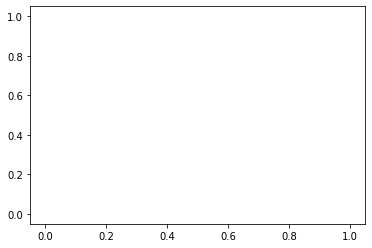

Wall time: 2min 16s


In [14]:
%%time
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne_exp4(X, 2, 50, perplexity=30.0)
    pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
    pylab.show()

In [15]:
#initial and final parameter changed
def tsne_exp5(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000 #The number of gradient descent iterations T
    initial_momentum = 0.1
    final_momentum = 2
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 400...
Mean value of sigma: 3.791231
Iteration 10: error is 15.063997
Iteration 20: error is 14.309087
Iteration 30: error is 13.821751
Iteration 40: error is 15.459640
Iteration 50: error is 15.453888


C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide


Iteration 60: error is 15.453883
Iteration 70: error is 15.453883
Iteration 80: error is 15.453883
Iteration 90: error is 15.453883
Iteration 100: error is 15.453883
Iteration 110: error is 2.477176
Iteration 120: error is 2.477176
Iteration 130: error is 2.477176
Iteration 140: error is 2.477176
Iteration 150: error is 2.477176
Iteration 160: error is 2.477176
Iteration 170: error is 2.477176
Iteration 180: error is 2.477176
Iteration 190: error is 2.477176
Iteration 200: error is 2.477176
Iteration 210: error is 2.477176
Iteration 220: error is 2.477176
Iteration 230: error is 2.477176
Iteration 240: error is 2.477176
Iteration 250: error is 2.477176
Iteration 260: error is 2.477176
Iteration 270: error is 2.477176
Iteration 280: error is 2.477176
Iteration 290: error is 2.477176
Iteration 300: error is 2.477176
Iteration 310: error is 2.477176
Iteration 320: error is 2.477176
Iteration 330: error is 2.477176
Iteration 340: error is 2.477176
Iteration 350: error is 2.477176
Iteration

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in add
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in square
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in multiply
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in add
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in greater


Iteration 540: error is nan
Iteration 550: error is nan
Iteration 560: error is nan
Iteration 570: error is nan
Iteration 580: error is nan
Iteration 590: error is nan
Iteration 600: error is nan
Iteration 610: error is nan
Iteration 620: error is nan
Iteration 630: error is nan
Iteration 640: error is nan
Iteration 650: error is nan
Iteration 660: error is nan
Iteration 670: error is nan
Iteration 680: error is nan
Iteration 690: error is nan
Iteration 700: error is nan
Iteration 710: error is nan
Iteration 720: error is nan
Iteration 730: error is nan
Iteration 740: error is nan
Iteration 750: error is nan
Iteration 760: error is nan
Iteration 770: error is nan
Iteration 780: error is nan
Iteration 790: error is nan
Iteration 800: error is nan
Iteration 810: error is nan
Iteration 820: error is nan
Iteration 830: error is nan
Iteration 840: error is nan
Iteration 850: error is nan
Iteration 860: error is nan
Iteration 870: error is nan
Iteration 880: error is nan
Iteration 890: error

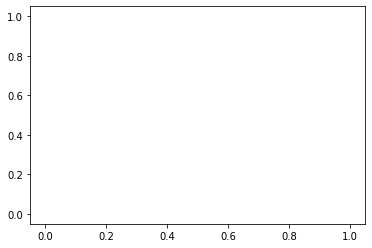

Wall time: 2min 15s


In [16]:
%%time
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne_exp5(X, 2, 50, perplexity=30.0)
    pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
    pylab.show()

In [17]:
#max iter threshold from 20(script) to 250(manuscript)
def tsne_exp6(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000 #The number of gradient descent iterations T
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 250:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 400...
Mean value of sigma: 3.791231
Iteration 10: error is 15.090289
Iteration 20: error is 13.826251
Iteration 30: error is 13.669258
Iteration 40: error is 13.585362
Iteration 50: error is 13.580056
Iteration 60: error is 13.526422
Iteration 70: error is 13.553899
Iteration 80: error is 13.558347
Iteration 90: error is 13.563307
Iteration 100: error is 13.568777
Iteration 110: error is 1.199832
Iteration 120: error is 0.779353
Iteration 130: error is 0.623376
Iteration 140: error is 0.554012
Iteration 150: error is 0.511590
Iteration 160: error is 0.484526
Iteration 170: error is 0.466335
Iteration 180: error is 0.453340
Iteration 190: error is 0.443672
Iteration 200: error is 0.436314
Iteration 210: error is 0.430896
Iteration 220: error is 0.426548
Iteration 230: er

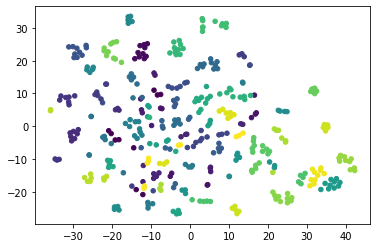

Wall time: 2min 7s


In [18]:
%%time
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne_exp6(X, 2, 50, perplexity=30.0)
    pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
    pylab.show()

In [19]:
#total number of iter, and iter_threshold

def tsne_exp7(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 500 #The number of gradient descent iterations T
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 250:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 400...
Mean value of sigma: 3.791231
Iteration 10: error is 14.285028
Iteration 20: error is 13.632333
Iteration 30: error is 13.561483
Iteration 40: error is 13.575127
Iteration 50: error is 13.578588
Iteration 60: error is 13.585938
Iteration 70: error is 13.575325
Iteration 80: error is 13.597997
Iteration 90: error is 13.580972
Iteration 100: error is 13.553787
Iteration 110: error is 1.201083
Iteration 120: error is 0.779422
Iteration 130: error is 0.624100
Iteration 140: error is 0.553921
Iteration 150: error is 0.510288
Iteration 160: error is 0.483029
Iteration 170: error is 0.464494
Iteration 180: error is 0.451424
Iteration 190: error is 0.441905
Iteration 200: error is 0.434585
Iteration 210: error is 0.428950
Iteration 220: error is 0.424490
Iteration 230: er

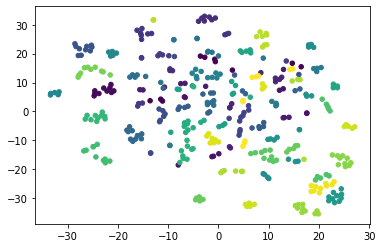

Wall time: 2min 1s


In [20]:
%%time
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne_exp7(X, 2, 50, perplexity=30.0)
    pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
    pylab.show()

In [21]:
#total number of iter

def tsne_exp8(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 500 #The number of gradient descent iterations T
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 400...
Mean value of sigma: 3.791231
Iteration 10: error is 15.037768
Iteration 20: error is 13.784142
Iteration 30: error is 13.549159
Iteration 40: error is 13.639958
Iteration 50: error is 13.623822
Iteration 60: error is 13.596753
Iteration 70: error is 13.605541
Iteration 80: error is 13.615387
Iteration 90: error is 13.581046
Iteration 100: error is 13.596523
Iteration 110: error is 1.077161
Iteration 120: error is 0.626273
Iteration 130: error is 0.514379
Iteration 140: error is 0.470461
Iteration 150: error is 0.447078
Iteration 160: error is 0.432935
Iteration 170: error is 0.424126
Iteration 180: error is 0.418638
Iteration 190: error is 0.415110
Iteration 200: error is 0.412624
Iteration 210: error is 0.410904
Iteration 220: error is 0.409652
Iteration 230: er

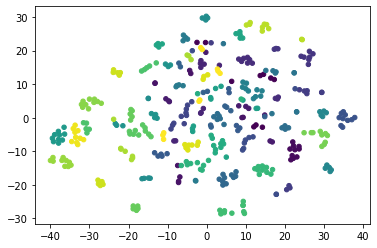

Wall time: 2min


In [22]:
%%time
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne_exp8(X, 2, 50, perplexity=30.0)
    pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
    pylab.show()

In [13]:
#initial and final parameter changed
def tsne_exp9(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1500 #The number of gradient descent iterations T
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 400...
Mean value of sigma: 3.791231
Iteration 10: error is 15.029486
Iteration 20: error is 13.891509
Iteration 30: error is 13.632042
Iteration 40: error is 13.697646
Iteration 50: error is 13.659949
Iteration 60: error is 13.633634
Iteration 70: error is 13.640031
Iteration 80: error is 13.631664
Iteration 90: error is 13.626847
Iteration 100: error is 13.642179
Iteration 110: error is 1.132640
Iteration 120: error is 0.670196
Iteration 130: error is 0.535134
Iteration 140: error is 0.483628
Iteration 150: error is 0.455655
Iteration 160: error is 0.439934
Iteration 170: error is 0.430452
Iteration 180: error is 0.424151
Iteration 190: error is 0.419687
Iteration 200: error is 0.416611
Iteration 210: error is 0.414358
Iteration 220: error is 0.412289
Iteration 230: er

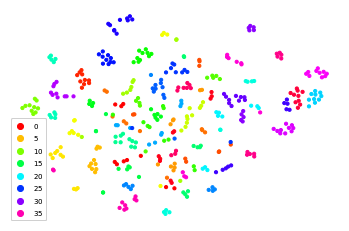

In [14]:
#Run original script parameters
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne_exp9(X, 2, 50, perplexity=30.0)
    fig, ax = plt.subplots()
    scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
    plt.axis('off')
    legend = ax.legend(*scatter.legend_elements(), fontsize=7)
    ax.add_artist(legend)
    plt.show()

In [15]:
#max_iter changed to 2000
def tsne_exp10(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 2000 #The number of gradient descent iterations T
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 400...
Mean value of sigma: 3.791231
Iteration 10: error is 14.436360
Iteration 20: error is 13.652888
Iteration 30: error is 13.679166
Iteration 40: error is 13.681078
Iteration 50: error is 13.627931
Iteration 60: error is 13.678807
Iteration 70: error is 13.621270
Iteration 80: error is 13.643776
Iteration 90: error is 13.664393
Iteration 100: error is 13.617280
Iteration 110: error is 1.108248
Iteration 120: error is 0.664007
Iteration 130: error is 0.538412
Iteration 140: error is 0.492659
Iteration 150: error is 0.470551
Iteration 160: error is 0.456540
Iteration 170: error is 0.446133
Iteration 180: error is 0.438419
Iteration 190: error is 0.433561
Iteration 200: error is 0.430561
Iteration 210: error is 0.428369
Iteration 220: error is 0.426563
Iteration 230: er

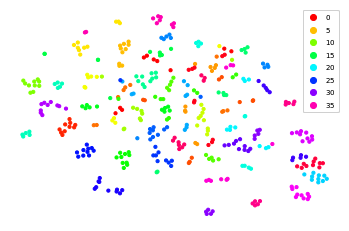

In [16]:
#Run original script parameters
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne_exp10(X, 2, 50, perplexity=30.0)
    fig, ax = plt.subplots()
    scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
    plt.axis('off')
    legend = ax.legend(*scatter.legend_elements(), fontsize=7)
    ax.add_artist(legend)
    plt.show()

In [17]:
#learning rate org(100) from script(500) changed
def tsne_exp11(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000 #The number of gradient descent iterations T
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 100
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 400...
Mean value of sigma: 3.791231
Iteration 10: error is 15.187048
Iteration 20: error is 14.428241
Iteration 30: error is 13.395165
Iteration 40: error is 13.466066
Iteration 50: error is 13.590339
Iteration 60: error is 13.540562
Iteration 70: error is 13.535439
Iteration 80: error is 13.547180
Iteration 90: error is 13.545316
Iteration 100: error is 13.543275
Iteration 110: error is 1.362470
Iteration 120: error is 0.890380
Iteration 130: error is 0.698726
Iteration 140: error is 0.598629
Iteration 150: error is 0.539861
Iteration 160: error is 0.501707
Iteration 170: error is 0.475961
Iteration 180: error is 0.457980
Iteration 190: error is 0.444918
Iteration 200: error is 0.435132
Iteration 210: error is 0.427723
Iteration 220: error is 0.422111
Iteration 230: er

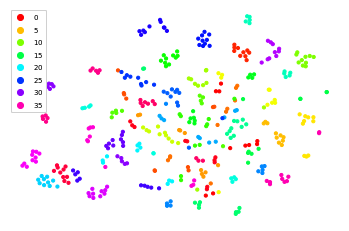

In [18]:
#Run original script parameters
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne_exp11(X, 2, 50, perplexity=30.0)
    fig, ax = plt.subplots()
    scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
    plt.axis('off')
    legend = ax.legend(*scatter.legend_elements(), fontsize=7)
    ax.add_artist(legend)
    plt.show()

In [19]:
#learning rate 50 from script(500) changed
def tsne_exp12(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000 #The number of gradient descent iterations T
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 50
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 400...
Mean value of sigma: 3.791231
Iteration 10: error is 15.151267
Iteration 20: error is 15.029555
Iteration 30: error is 13.556122
Iteration 40: error is 13.288372
Iteration 50: error is 13.466332
Iteration 60: error is 13.572467
Iteration 70: error is 13.570923
Iteration 80: error is 13.544713
Iteration 90: error is 13.539335
Iteration 100: error is 13.543814
Iteration 110: error is 1.506857
Iteration 120: error is 1.047790
Iteration 130: error is 0.831717
Iteration 140: error is 0.713106
Iteration 150: error is 0.636753
Iteration 160: error is 0.583489
Iteration 170: error is 0.545865
Iteration 180: error is 0.518358
Iteration 190: error is 0.497677
Iteration 200: error is 0.481796
Iteration 210: error is 0.469383
Iteration 220: error is 0.459522
Iteration 230: er

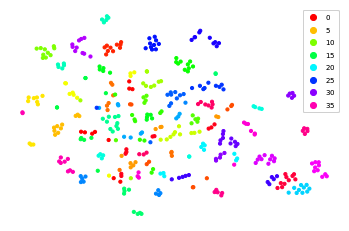

In [20]:
#Run original script parameters
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne_exp12(X, 2, 50, perplexity=30.0)
    fig, ax = plt.subplots()
    scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
    plt.axis('off')
    legend = ax.legend(*scatter.legend_elements(), fontsize=7)
    ax.add_artist(legend)
    plt.show()

In [21]:
#learning rate 250 from script(500) changed
def tsne_exp13(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000 #The number of gradient descent iterations T
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 250
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 400...
Mean value of sigma: 3.791231
Iteration 10: error is 14.374271
Iteration 20: error is 13.618386
Iteration 30: error is 13.503904
Iteration 40: error is 13.555007
Iteration 50: error is 13.553932
Iteration 60: error is 13.539499
Iteration 70: error is 13.552268
Iteration 80: error is 13.541685
Iteration 90: error is 13.546254
Iteration 100: error is 13.542131
Iteration 110: error is 1.182363
Iteration 120: error is 0.719973
Iteration 130: error is 0.567975
Iteration 140: error is 0.503302
Iteration 150: error is 0.469466
Iteration 160: error is 0.449173
Iteration 170: error is 0.436159
Iteration 180: error is 0.427471
Iteration 190: error is 0.421464
Iteration 200: error is 0.417047
Iteration 210: error is 0.413589
Iteration 220: error is 0.411074
Iteration 230: er

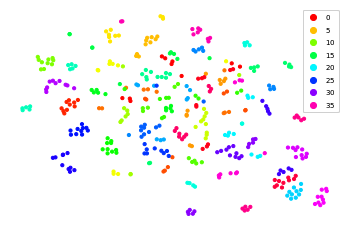

In [22]:
#Run original script parameters
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne_exp13(X, 2, 50, perplexity=30.0)
    fig, ax = plt.subplots()
    scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
    plt.axis('off')
    legend = ax.legend(*scatter.legend_elements(), fontsize=7)
    ax.add_artist(legend)
    plt.show()